In [1]:
import itertools
import pathlib

import pooch
import pyam
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

<IPython.core.display.Javascript object>

In [2]:
datapath = pathlib.Path('../data')
sheet_names = ['core', 'sensitivities', 'governance']

In [11]:
color_map = {
    'C1-1.5°C low/no overshoot': 'AR6-C1',
    'C2-1.5°C high overshoot': 'AR6-C2',
    'C3-Below 2°C>67%': 'AR6-C3',
}
pyam.run_control().update({'color': {'Temperature': color_map}})

In [4]:
fulldf = pyam.IamDataFrame(pooch.retrieve("doi:10.5281/zenodo.7986556/gidden_brutschin_et_al_2023.xlsx", known_hash="md5:ee1c89ca2829380fca9fbda79423813d", fname="gidden_brutshin_et_al_2023_data.csv", path = datapath))

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ..\data\gidden_brutshin_et_al_2023_data.csv


In [5]:
fulldf.load_meta(datapath / 'gidden_brutshin_et_al_2023_meta.csv')

pyam.core - INFO: Reading meta indicators


In [7]:
for sheet_name in sheet_names:
    fulldf.load_meta(datapath / 'scenarios_assessed.xlsx', sheet_name=sheet_name, ignore_conflict=True)

pyam.core - INFO: Reading meta indicators for 6 out of 30 scenarios
pyam.core - INFO: Reading meta indicators for 12 out of 30 scenarios
pyam.core - INFO: Reading meta indicators for 12 out of 30 scenarios


In [8]:
n_scenario_all = 6 + 12 + 12
assert len(fulldf.scenario) == n_scenario_all

# Figure 1: CO2 Emissions

In [54]:
variables = [
    'Emissions|CO2',
    'Emissions|Kyoto Gases',
]
df = fulldf.filter(variable=variables).convert_unit('Mt CO2/yr', to='Gt CO2/yr', factor=1e-3)

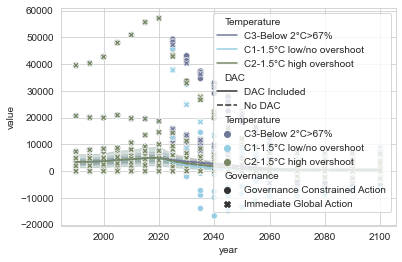

In [55]:
# get legend data via seaborn

pdata = df.as_pandas()

palette = {t: pyam.plotting.PYAM_COLORS[c] for t, c in color_map.items()}
sns.lineplot(
    data=pdata,
    x="year", y="value", hue="Temperature", style="DAC", palette=palette,
)

ax = sns.scatterplot(
    data=pdata,
    x="year", y="value", hue="Temperature", style="Governance", style_order=['Governance Constrained Action', 'Immediate Global Action'], palette=palette,
)
handles, labels = ax.get_legend_handles_labels()

In [56]:
labels

['Temperature',
 'C3-Below 2°C>67%',
 'C1-1.5°C low/no overshoot',
 'C2-1.5°C high overshoot',
 'DAC',
 'DAC Included',
 'No DAC',
 'Temperature',
 'C3-Below 2°C>67%',
 'C1-1.5°C low/no overshoot',
 'C2-1.5°C high overshoot',
 'Governance',
 'Governance Constrained Action',
 'Immediate Global Action']

c:\users\gidden\onedrive - iiasa\work\iiasa\pyam\pyam\plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
c:\users\gidden\onedrive - iiasa\work\iiasa\pyam\pyam\plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
c:\users\gidden\onedrive - iiasa\work\iiasa\pyam\pyam\plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():


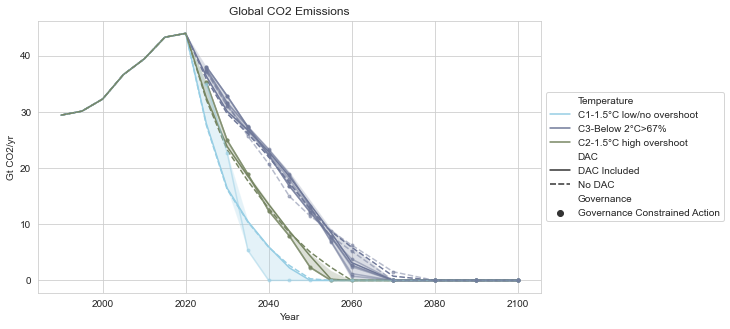

In [57]:
scale = 2
fig, ax = plt.subplots(figsize=(4.5 * scale, 2.5 * scale))
data = df.filter(variable='Emissions|CO2', region='World', year=range(1990, 2101))
(
    data
    .filter(Illustrative='Yes', Governance='Immediate Global Action')
    .plot
    .line(color='Temperature', linestyle='DAC', ax=ax)
)
(
    data
    .filter(DAC='DAC Included')
    .plot
    .line(color='Temperature', linestyle='DAC', ax=ax,
         fill_between=True, alpha=0)
)
(
    data
    .filter(year=range(2021, 2101))
    .filter(Governance='Governance Constrained Action')
    .plot
    .line(color='Temperature', marker='Governance', linestyle='DAC', ax=ax, alpha=0.5, legend=False, markersize=3)
)
ax.set_title('Global CO2 Emissions')
t_order = [0, 2, 1, 3, 4, 5, 6, 11, 12]
ax.legend([handles[t] for t in t_order], [labels[t] for t in t_order], **dict(loc="center left", bbox_to_anchor=(1.0, 0.5)))

fig.savefig('./files/fig1.svg', bbox_inches='tight')

# Figure 2: CDR Outcomes

In [58]:
variables = [
    'Emissions|CO2',
    'Carbon Sequestration|*',
    '*CDR*',
]
df = (
    fulldf
    .filter(variable=variables)
    .filter(scenario='EN_NPi2020-DACn-MP-median-stor3-phs-govm_500', keep=False) # remove no-limit DAC
)

c:\users\gidden\onedrive - iiasa\work\iiasa\pyam\pyam\plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():


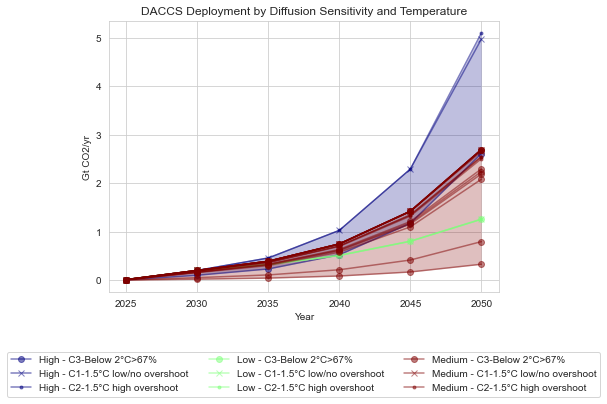

In [59]:
fig, ax = plt.subplots(figsize=(7, 5))
ax = (
    df
    .filter(variable='Carbon Sequestration|Direct Air Capture', region='World', year=range(1990, 2051))
    .filter(DAC='DAC Included')
    .convert_unit('Mt CO2/yr', to='Gt CO2/yr', factor=1e-3)
    .plot
    .line(
        color='Diffusion', marker='Temperature', cmap='jet',
        legend={'loc': 'outside bottom'}, alpha=0.5, fill_between=True,
        ax=ax,
    )
)
ax.set_title('DACCS Deployment by Diffusion Sensitivity and Temperature')

fig.savefig('./files/fig2.svg', bbox_inches='tight')

# Figure 3 & 4a: CDR substitution globally

In [60]:
variables = [
    '*Carbon Sequestration|*',
    '*CDR*',
]
df = (
    fulldf
    .filter(variable=variables)
    .filter(scenario='EN_NPi2020-DACn-MP-median-stor3-phs-govm_500', keep=False) # remove no-limit DAC
    .filter(scenario='EN_NPi2020-median-stor3-phs-govmSSP*-CO2total_1000', keep=False) # remove no-DAC governance cases
)
df.head()

,model,scenario,region,variable,unit,year,value
0,GENIE_SSP2_v4.1.7,EN_NPi2020-DACh-MP-median-stor3-final_1000,AFR,CDR,Mt CO2/yr,1990,4.0876
1,GENIE_SSP2_v4.1.7,EN_NPi2020-DACh-MP-median-stor3-final_1000,AFR,CDR,Mt CO2/yr,1995,4.0876
2,GENIE_SSP2_v4.1.7,EN_NPi2020-DACh-MP-median-stor3-final_1000,AFR,CDR,Mt CO2/yr,2000,4.0876
3,GENIE_SSP2_v4.1.7,EN_NPi2020-DACh-MP-median-stor3-final_1000,AFR,CDR,Mt CO2/yr,2005,8.7318
4,GENIE_SSP2_v4.1.7,EN_NPi2020-DACh-MP-median-stor3-final_1000,AFR,CDR,Mt CO2/yr,2010,13.3760


In [61]:
df.meta.Governance.unique()

array(['Immediate Global Action', 'Governance Constrained Action'],
      dtype=object)

In [62]:
assert len(df.scenario) == n_scenario_all - 3

In [63]:
def make_data_no_gov(df, region='World', variable='Cumulative CDR from 2020', year=2050, relative=True):
    data = (
        df
        .filter(variable=variable, year=year, region=region)
        .filter(Governance='Immediate Global Action')
        .convert_unit('Mt CO2/yr', to='Gt CO2/yr', factor=1e-3)
        .as_pandas()
        .set_index(['DAC', 'Temperature', 'region', 'model', 'scenario'])
        ['value']
        .rename(variable)
    )
    pdata = (
        (data.loc['DAC Included'] - data.loc['No DAC'].droplevel(['model', 'scenario']))
    )
    if relative:
        pdata = 100 * pdata /  data.loc['No DAC'].droplevel(['model', 'scenario'])
    return data, pdata.reset_index()

In [74]:
idx = ['model', 'scenario']
def make_data_gov(df, region='World', variable='Cumulative CDR from 2020', year=2050, relative=True):
    data = df.filter(variable=variable, year=year, region=region)
    data = (
        pyam.concat([
            data.filter(DAC='DAC Included', Governance='Immediate Global Action', Diffusion='Medium'), # standard scenarios
            data.filter(Governance='Governance Constrained Action', Technoeconomic='Medium', Temperature='C2-1.5°C high overshoot', **{'Governance SSP': 'SSP1'}),
            data.filter(Governance='Governance Constrained Action', Technoeconomic='Medium', Temperature='C3-Below 2°C>67%', **{'Governance SSP': 'SSP2'}),
        ])
        .filter(Temperature='C1-1.5°C low/no overshoot', keep=False) # no 1.5C governance scenarios
        .convert_unit('Mt CO2/yr', to='Gt CO2/yr', factor=1e-3)
        .as_pandas()
        .set_index(['Governance', 'Temperature', 'region', 'model', 'scenario'])
        ['value']
        .rename(variable)
    )
    pdata = (
        (data.loc['Governance Constrained Action'] - data.loc['Immediate Global Action'].droplevel(idx))
    )
    if relative:
        pdata = 100 * pdata /  data.loc['Governance Constrained Action'].droplevel(idx)
    return data, pdata.reset_index()

In [75]:
def cumulative_cdr_for_year(df, year, relative=True, gov=False):
    variables = {
        'Cumulative Carbon Sequestration|CCS|Biomass from 2020': 'BECCS',
        'Cumulative CDR from 2020': 'Total',
        'Cumulative Carbon Sequestration|Land Use from 2020': 'A/R',
    }
    if gov:
        variables['Cumulative Carbon Sequestration|Direct Air Capture from 2020'] = 'DACCS'
    _pdata = []
    for variable in list(variables.keys()):
        if gov:
            _, pdf = make_data_gov(df, region='World', variable=variable, year=year, relative=relative)
        else:
            _, pdf = make_data_no_gov(df, region='World', variable=variable, year=year, relative=relative)
            
        _pdata.append(pdf.set_index(['Temperature', 'region',  'model', 'scenario']))
    pdata = pd.concat(_pdata, axis=1).rename(columns=variables)
    pdata = pd.melt(pdata, value_vars=pdata.columns, ignore_index=False)
    return pdata

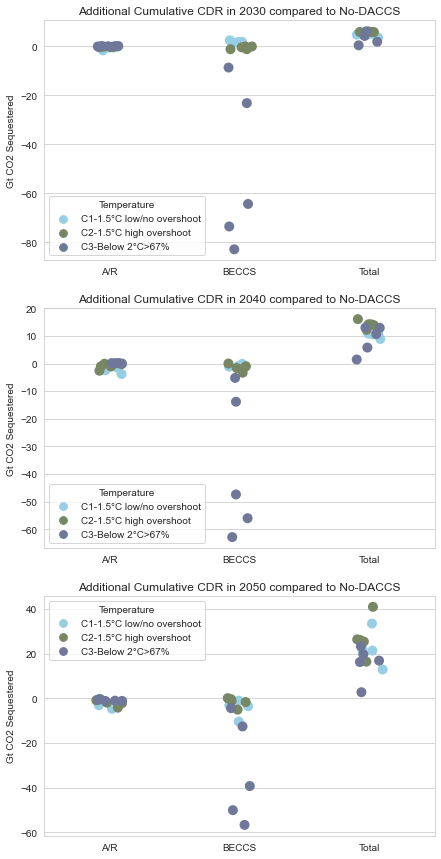

In [86]:
relative = False
ylabel = '% Change' if relative else 'Gt CO2 Sequestered'

fig, axs = plt.subplots(3, 1, figsize=(7, 5 * 3))
for ax, year in zip(axs, [2030, 2040, 2050]):
    hue_order = ['A/R', 'BECCS', 'Total']
    pdata = cumulative_cdr_for_year(df, year, relative=True)
    sns.stripplot(
        data=pdata.reset_index(), x="variable", y="value", hue='Temperature', palette=palette,
        order=hue_order, size=10, 
        #dodge=True, jitter=False, 
        ax=ax
    )
    ax.set_xlabel('')
    ax.set_ylabel(ylabel)
    ax.set_title(f'Additional Cumulative CDR in {year} compared to No-DACCS')
    fig.savefig(f'files/fig3.svg')

In [77]:
pdata.groupby('variable').quantile((0, 1)) # claim on difference in sequestered values by scenario

value
variable               
A/R      0.0  -4.665839
         1.0  -0.360445
BECCS    0.0 -56.625356
         1.0   0.095964
Total    0.0   2.748894
         1.0  40.946452

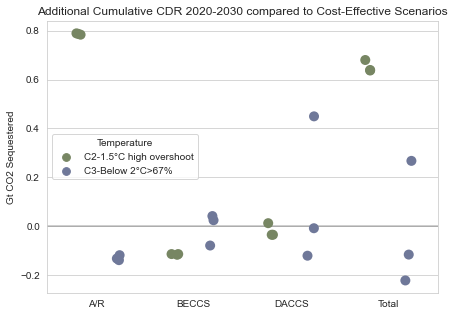

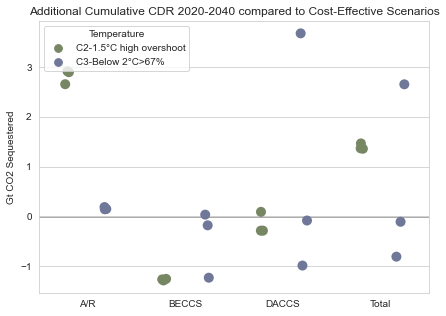

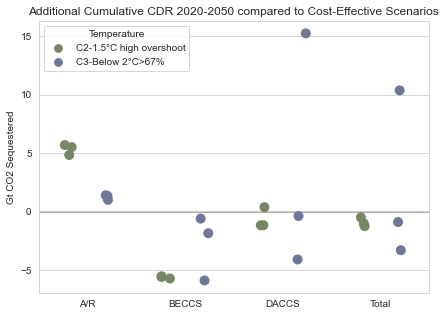

In [78]:
relative = False
ylabel = '% Change' if relative else 'Gt CO2 Sequestered'

for label, year in zip(['a1', 'a2', 'a3'], [2030, 2040, 2050]):
    fig, ax = plt.subplots(figsize=(7, 5))
    hue_order = ['A/R', 'BECCS', 'DACCS', 'Total']
    pdata = cumulative_cdr_for_year(df, year, relative=relative, gov=True)

    sns.stripplot(
        data=pdata.reset_index(), x="variable", y="value", hue='Temperature', palette=palette,
        order=hue_order, size=10, 
        dodge=True, jitter=True, 
        ax=ax
    )

    ax.set_xlabel('')
    ax.axhline(0, c='k', alpha=0.25)
    ax.set_ylabel(ylabel)
    ax.set_title(f'Additional Cumulative CDR 2020-{year} compared to Cost-Effective Scenarios')
    fig.savefig(f'files/fig4{label}.svg')

# Figure 4b: CDR Substitution Regionally

In [79]:
native_regions = [
    'AFR',
     'CPA',
     'EEU',
     'FSU',
     'LAM',
     'MEA',
     'NAM',
     'PAO',
     'PAS',
     'SAS',
     'WEU',
]
region = list(
    set(df.region) - set(native_regions)
)
region

['World',
 'China & Centrally Planned Asia',
 'Latin America',
 'Asia',
 'Africa',
 'Developed Regions']

In [80]:
replace = {'region': {
    'Developed Regions': 'Developed\nRegions',
    'Africa': 'Middle East &\nAfrica',
    'Asia': 'South &\nSouth East Asia',
    'Latin America': 'Latin\nAmerica',
    'China & Centrally Planned Asia': 'China & Centrally\nPlanned Asia',
}}

In [81]:
def make_region_data_no_gov(df, region):
    data = (
        df
        .filter(variable='Cumulative CDR from 2020', year=2050, region=region)
        .filter(Governance='Immediate Global Action')
        .as_pandas()
        .set_index(['DAC', 'Temperature', 'region'])
        ['value']
    )
    pdata = (
        (100 * (data.loc['DAC Included'] - data.loc['No DAC']) / data.loc['No DAC'])
        .reset_index()
#        .replace({'Temperature': {'C2-1.5°C high overshoot': '1.5C low/high', 'C1-1.5°C low/no overshoot': '1.5C low/high'}})
    )
    return data, pdata

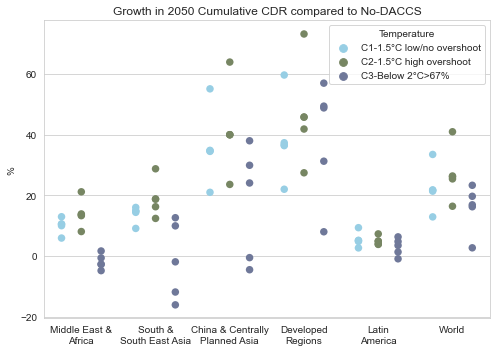

In [82]:
data, pdata = make_region_data_no_gov(df, region=region)
pdata = pdata.replace(replace)

fig, ax = plt.subplots(figsize=(7, 5))
#sns.boxplot(data=pdata, x="region", y="value", hue='Temperature', ax=ax, showfliers=False)
sns.stripplot(
    data=pdata, x="region", y="value", hue='Temperature', palette=palette,
    dodge=True, jitter=False, size=7.5, 
    ax=ax
)

ax.set_xlabel('')
ax.set_ylabel('%')
ax.set_title('Growth in 2050 Cumulative CDR compared to No-DACCS')
plt.tight_layout()

fig.savefig('files/fig4b1.svg', bbox_inches='tight')

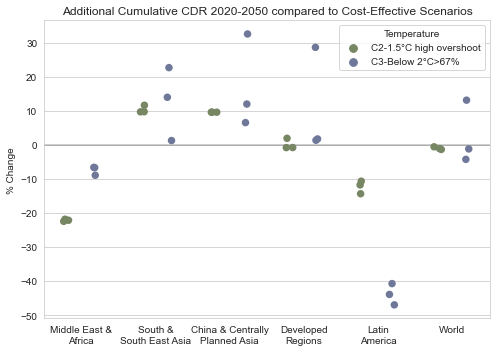

In [83]:
relative = True
ylabel = '% Change' if relative else 'Gt CO2 Sequestered'

data, pdata = make_data_gov(df, region, relative=relative)
pdata = pdata.replace(replace)

fig, ax = plt.subplots(figsize=(7, 5))
#sns.boxplot(data=pdata, x="region", y="value", hue='Temperature', ax=ax, showfliers=False)
sns.stripplot(
    data=pdata, x="region", y="Cumulative CDR from 2020", hue='Temperature', palette=palette,
    dodge=True, jitter=True, size=7.5, 
    ax=ax
)

ax.set_xlabel('')
ax.set_ylabel(ylabel)
ax.axhline(0, c='k', alpha=0.25)
ax.set_title(f'Additional Cumulative CDR 2020-{year} compared to Cost-Effective Scenarios')
plt.tight_layout()

fig.savefig('files/fig4b2.svg', bbox_inches='tight')